In [30]:
%matplotlib inline

In [31]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import seaborn as sns
from graph_tool import GraphView
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score
from collections import OrderedDict, defaultdict
from matplotlib import pyplot as plt

from helpers import infected_nodes, cascade_source
from graph_helpers import load_graph_by_name, remove_filters, get_edge_weights, extract_edges, extract_nodes
from random_steiner_tree.util import from_gt
from viz_helpers import lattice_node_pos
from sample_pool import TreeSamplePool
from query_selection import PredictionErrorQueryGenerator, WeightedPredictionErrorQueryGenerator
from simulator import Simulator
from tree_stat import TreeBasedStatistics
from experiment import gen_input
from root_sampler import build_true_root_sampler
from inference import infection_probability

from viz_helpers import visualize, query_plot_setting, default_plot_setting, tree_plot_setting, set_cycler, InfectionProbabilityViz
from eval_helpers import get_scores_by_queries

In [32]:
graph = 'grqc-sto'
graph_suffix = '_rev'
num_queries_to_show = 5
sampling_method = 'loop_erased'
obs_frac = "0.2"
cascade_fraction = "0.025"
obs_method = 'uniform'
cascade_model = 'ic'
dataset_id = '{}-m{}-s{}-o{}-om{}'.format(graph, cascade_model, cascade_fraction, obs_frac, obs_method)
cascade_dir = 'cascade-weighted/{}'.format(dataset_id)
fig_dirname = 'figs/inspect-query-process/{}'.format(dataset_id)

query_dir = 'outputs/queries-weighted/{}/{}/'.format(dataset_id, sampling_method)
probas_dir = 'outputs/inf_probas-weighted/{}/{}/'.format(dataset_id, sampling_method)
cascade_id = 0

if not os.path.exists(fig_dirname):
    os.makedirs(fig_dirname)

In [48]:
SHOW_IN_NB = True

In [34]:
query_methods = ['random', 'pagerank', 'entropy', 'prediction_error', 'mutual-info', 'oracle-e', 'oracle-l']


In [35]:
g = load_graph_by_name(graph, weighted=True, suffix=graph_suffix)
if graph.startswith('lattice'):
    n = int(np.sqrt(g.num_vertices()))
    pos = lattice_node_pos(g, shape=(n, n))
else:
    pos = sfdp_layout(g)

load graph from data/grqc-sto/graph_weighted_rev.gt


In [49]:
obs, c = pkl.load(open('{}/{}.pkl'.format(cascade_dir, cascade_id), 'rb'))[:2]
inf_nodes = infected_nodes(c)
source = cascade_source(c)
print('cascade size', len(infected_nodes(c)))

cascade size 105


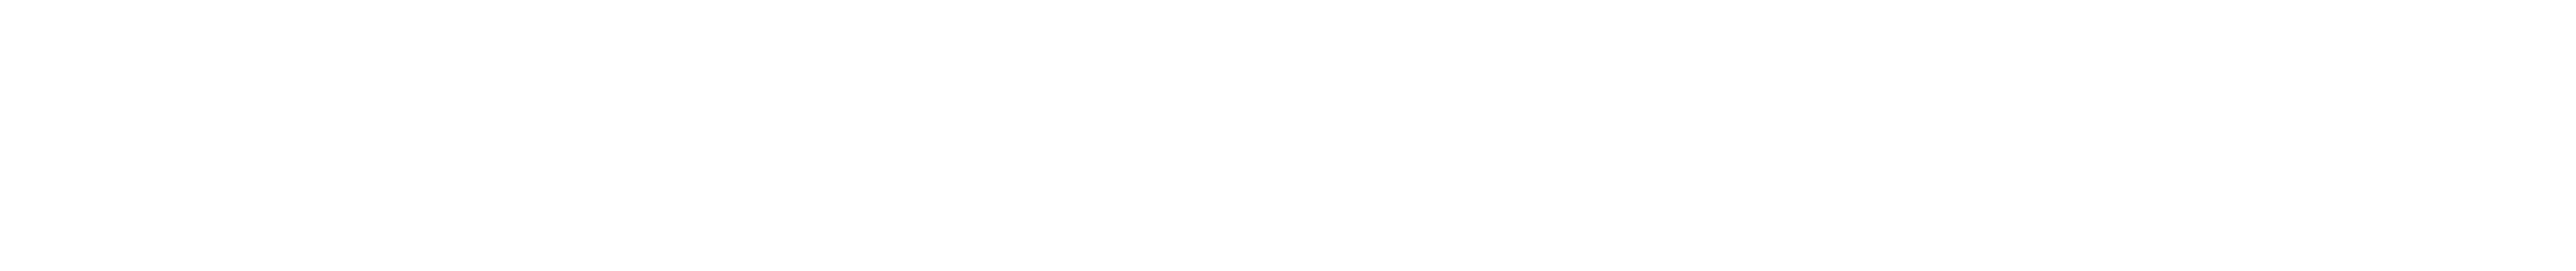

In [50]:
size = 10
plt.switch_backend('cairo')

fig, axes = plt.subplots(1, len(query_methods) + 1, figsize=(size * (len(query_methods) + 3), size))
for ax in axes:
    ax.axis('off')

In [51]:
# plot cascade and observations
setting = default_plot_setting(g, c, obs)
visualize(g, pos,
          **setting,
          output='{}/cascade.png'.format(fig_dirname),
          ax=(axes[0] if SHOW_IN_NB else None))

In [52]:
# 'pagerank', 
# query_method = 'prediction_error'
n_queries_to_show = 100

def load_qs_and_probas(query_method):
    query_file_path = os.path.join(query_dir, query_method, '{}.pkl'.format(cascade_id))
    proba_file_path = os.path.join(probas_dir, query_method, '{}.pkl'.format(cascade_id))
    qs, _ = pkl.load(open(query_file_path, 'rb'))
    qs = qs[:n_queries_to_show]
    probas = pkl.load(open(proba_file_path, 'rb'))
    return qs, probas



In [53]:
# plot the queries
for ax, query_method in zip(axes[1:], query_methods):
    print(query_method)
    qs, probas = load_qs_and_probas(query_method)
    s = query_plot_setting(g, c, obs, qs, indicator_type=['color'])
    ax.set_title(query_method, fontdict={'fontsize': 28})    
    ax.axis('off')
    visualize(g, pos, **s, 
              ax=(ax if SHOW_IN_NB else None),
              output='{}/queries-by-{}.png'.format(fig_dirname, query_method))

random
pagerank
entropy
prediction_error
mutual-info
oracle-e
oracle-l


In [54]:
fig.savefig('{}/queries.png'.format(fig_dirname))

random 100 21
pagerank 100 21
entropy 100 21
prediction_error 100 21
mutual-info 100 21
oracle-e 84 17


IndexError: list index out of range

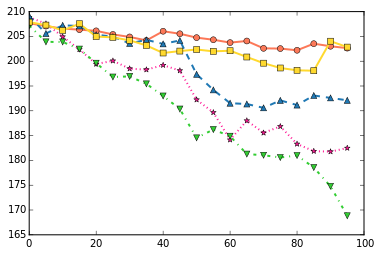

In [47]:
# plot the score
score_list = defaultdict(list)

ax = plt.subplot()
set_cycler(ax)
eval_method = 'l1'
every = 5

for query_method in query_methods:
    qs, probas = load_qs_and_probas(query_method)
    probas = probas[0:1] + probas[1:int(len(qs) / every)+1]  # truncate probas 
    
    print(query_method, len(qs), len(probas))    

    def record_node_scores(scores):
        global score_list
        score_list[query_method].append(scores)    
        
    scores = get_scores_by_queries(qs, probas, c, obs, eval_method=eval_method,
                                   every=every,
                                   eval_with_mask=True,
                                   node_score_callback=record_node_scores)

    x = np.arange(0, len(scores)) * every
    ax.plot(x, scores)
# ax.legend(query_methods, loc='best')
ax.set_title(eval_method)

# ax.set_ylim(-0.05, 1.05)
# plt.show()
print(fig_dirname)
plt.savefig('{}/{}_score.png'.format(fig_dirname, eval_method))


In [ ]:
def intercept_f(setting):
    s = query_plot_setting(g, c, obs, qs, indicator_type=None)
    del s['node_color_info']
    setting.update(s)
viz.plot(c, obs, probas[int(n_queries_to_show / every)], interception_func=intercept_f)

In [ ]:
# plot loss

qs, probas = load_qs_and_probas('entropy')
viz = InfectionProbabilityViz(g, pos)
hidden_infs = set(inf_nodes) - (set(obs) | set(qs))
depth = score_list['entropy'][-1]
# depth = probas[int(n_queries_to_show / every)]
viz.plot(c, obs, depth, intercept_f)

In [ ]:
# plot loss

qs, probas = load_qs_and_probas('prediction_error')
viz = InfectionProbabilityViz(g, pos)
hidden_infs = set(inf_nodes) - (set(obs) | set(qs))
depth = score_list['prediction_error'][-1]
# depth = probas[int(n_queries_to_show / every)]
viz.plot(c, obs, depth, intercept_f)

In [ ]:
gv = remove_filters(g)  # the reserved graph

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=2500,
    method=sampling_method,
    gi=gi,
    return_type='nodes',
    with_resampling=False,
    with_inc_sampling=False)

params = {'n_node_samples': None,
          'prune_nodes': True,
          'root_sampler': 'true_root',
          'root_sampler_eps': 0.0,
          'min_proba': 0.05,
          'n_node_samples': None,
          'error_estimator': TreeBasedStatistics(gv)}
q_gen = PredictionErrorQueryGenerator(gv, sampler, **params, verbose=True)
sim = Simulator(gv, q_gen, gi=gi, print_log=True)

In [ ]:
n_queries_to_show = 10
qs_, _ = sim.run(n_queries_to_show, obs, c)

In [ ]:
query_scores = np.zeros(g.num_vertices())
for v, s in q_gen.query_scores.items():
    query_scores[int(v)] = s
query_scores[query_scores==0] = query_scores.max()  # make scores for observed maximum
query_scores -= query_scores.min() # from 0 to max-min
query_scores /= query_scores.max() # [0, 1]
if True:
    query_scores = 1 - query_scores  # invert it, the larger the score, the betterq


In [ ]:
from viz_helpers import InfectionProbabilityViz
viz = InfectionProbabilityViz(g, pos)
def f(s):
    s['node_shape_info'][tuple(qs_)] = 'triangle'
    s['node_size_info'][tuple(qs_)] = 20
viz.plot(c, obs, query_scores, f,
         output='{}/query_score_{}.png'.format(fig_dirname, 'prederror'))


In [57]:
source

2770

In [60]:
from core import sample_steiner_trees
gv = remove_filters(g)  # the reserved graph

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

trees = sample_steiner_trees(g, obs, 'loop_erased',
                     n_samples=5000,
                     gi=gi,
                     root=source,
                            log=True)



100%|██████████| 5000/5000 [00:03<00:00, 1565.21it/s]


In [62]:
sz = list(map(len, trees))

In [65]:
len(inf_nodes)

105

(array([  13.,  115.,  520., 1019., 1336., 1110.,  617.,  194.,   63.,
          13.]),
 array([102. , 120.2, 138.4, 156.6, 174.8, 193. , 211.2, 229.4, 247.6,
        265.8, 284. ]),
 <a list of 10 Patch objects>)

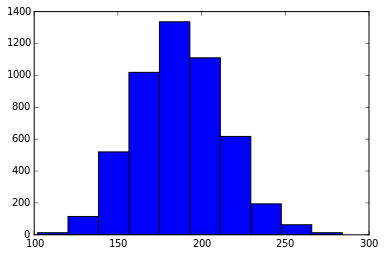

In [63]:
plt.hist(sz)